In [1]:
import tensorflow as tf
import os 
from pathlib import Path
import urllib.request as request
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = (224, 224)

In [3]:
model = tf.keras.applications.VGG16(
    include_top=True, #Do we want to include upper layers or not
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    classes=1000
)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553476096/553467096 [==============================] - 219s 0us/step


In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
model.save("VGG16_f11_model.h5")

In [6]:
model.layers[1].padding

'same'

In [7]:
main_data_dir = Path('hymenoptera_data/hymenoptera_data/train')
main_data_dir

WindowsPath('hymenoptera_data/hymenoptera_data/train')

In [8]:
BATCH_SIZE = 32
pixels = 224
IMAGE_SIZE = (pixels, pixels)

In [23]:
datagen_kwargs = dict(
    rescale=1./255,
    validation_split=0.20
)

dataflow_kwargs = dict(
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

In [24]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    main_data_dir, 
    subset="validation",
    shuffle=False,
    **dataflow_kwargs
)

do_data_augmentation = False

if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotational_range=40,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        **datagen_kwargs
    )
else:
    train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
    main_data_dir,
    subset="training",
    shuffle=True,
    **dataflow_kwargs
)

Found 48 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [25]:
RGB_IMAGE_SIZE = (pixels, pixels, 3)

vgg = tf.keras.applications.VGG16(
    input_shape=RGB_IMAGE_SIZE,
    weights="imagenet",
    include_top=False
)

58900480/58889256 [==============================] - 22s 0us/step


In [26]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
for layer in vgg.layers:
    layer.trainable = False

In [31]:
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [32]:
CLASSES = 2
x = tf.keras.layers.Flatten()(vgg.output)
prediction = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)

model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [35]:
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)

Epoch 1/10
7/7 [==============================] - 104s 15s/step - loss: 11.0407 - accuracy: 0.5612 - val_loss: 38.3984 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 109s 16s/step - loss: 92.1031 - accuracy: 0.4439 - val_loss: 41.4923 - val_accuracy: 0.5000
Epoch 3/10
7/7 [==============================] - 104s 16s/step - loss: 47.1653 - accuracy: 0.5000 - val_loss: 89.1053 - val_accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 103s 17s/step - loss: 42.3525 - accuracy: 0.5255 - val_loss: 2.9590 - val_accuracy: 0.7917
Epoch 5/10
7/7 [==============================] - 104s 17s/step - loss: 21.9828 - accuracy: 0.6633 - val_loss: 15.8477 - val_accuracy: 0.6250
Epoch 6/10
7/7 [==============================] - 107s 16s/step - loss: 22.2362 - accuracy: 0.6990 - val_loss: 13.5215 - val_accuracy: 0.7292
Epoch 7/10
7/7 [==============================] - 87s 12s/step - loss: 16.5806 - accuracy: 0.7296 - val_loss: 5.8414 - val_accuracy: 0.8125
Epoch 8/1

In [36]:
model.save('trained_model.h5')

In [39]:
label_map = {v:k for k, v in train_generator.class_indices.items()}

In [40]:
label_map

{0: 'ants', 1: 'bees'}

In [41]:
img_path = Path("hymenoptera_data/hymenoptera_data/val/ants/10308379_1b6c72e180.jpg")

In [42]:
img = plt.imread(img_path)

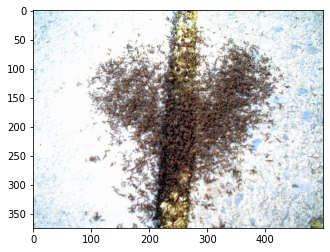

In [43]:
plt.imshow(img)

In [44]:
img.shape

(375, 500, 3)

In [46]:
resized_img = tf.image.resize(img, (224, 224))

In [49]:
input_data = tf.expand_dims(resized_img, axis=0)

In [62]:
pred = model.predict(input_data)
argmax_val = tf.argmax(pred[0]).numpy()

In [63]:
label_map[argmax_val]

'ants'